# Analysis of Kopp Dataset (Erlangen / Disphagia)
TLDR: Disphagia dataset with uncut videos of swallows from different perspectives

Pros:
- patient information
- labels for conditions

Challenges / Todos:
- [ ] multiple perspectives (1-20, ~5) -> Identify correct perspectives (heuristic or CNN Classification)
    - perspectives: lateral, frontal, zoomed in lateral and movement doing scan
    - [ ] sometimes >1 video from correct perspective -> choose one
- [ ] uncut videos -> Identify swallows and cut videos
- [ ] Some videos have movements in them (of patient or camera) -> further analysis
- only disphagia, no normals

Questions:
- Is one video one swallow? What is one swallow? Are even multiple small swallows seperate swallows?

### Folder Structure:
- patient id dcm folders
   - 560 patient identifiers
  - every patient folder can have multiple subfolders/videos with dcm file
- Diagnosen und Prozeduren folder
   - Diagnosen_psuedonymisiert.csv
      -  Columns: PATIENT_ID	FALL_ID	ICD_CODE	DIAGNOSE_DATUM	GEWISSHEIT_ID
      - 3,742 rows
  - Prozeduren_pseudonymisiert.csv
      - Columns: PATIENT_ID	FALL_ID	OPS_CODE PROZEDUR_DATUM
      - 1,523 rows
- extracted_videos_and_images folder
   - extracted mp4 files from dcm files per video id
- Kopp_Data_Overview.xlsx
   - columns:
      - Birth Year
      - Age
      - Sex
      - Manufacturer
      - Manufacturer's Model Name
      - Device Serial Number
      - Image/ Video Identifier
      - Comments about the Image/ Video
    -  3,018 rows
    - prob. just extracted info from dicom files
- README.md
   - mentions test sample ids


In [8]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [9]:
overview_path = r"\\fauad.fau.de\shares\ANKI\Projects\Swallowing\Data\from_Kopp\Kopp_Data_Overview.xlsx"
# load the data
# consits of png and video files
df_overview = pd.read_excel(overview_path)
df_overview.describe()

,PatID,Acquisition Date,Accession Number,Birth Year,Device Serial Number
count,3.017000e+03,3.017000e+03,3.017000e+03,3017.000000,3017.000000
mean,3.154024e+09,2.008817e+07,3.151936e+15,1947.239642,56521.360623
std,1.988040e+09,3.214143e+04,2.102813e+15,12.273839,4811.974441
min,1.000160e+09,2.002012e+07,1.000042e+15,1916.000000,5126.000000
25%,1.963818e+09,2.006042e+07,1.826643e+15,1940.000000,57031.000000
50%,2.642101e+09,2.009052e+07,2.591667e+15,1947.000000,57031.000000
75%,3.274797e+09,2.011103e+07,3.197203e+15,1953.000000,57031.000000
max,9.998359e+09,2.015033e+07,9.994461e+15,2003.000000,57031.000000


In [10]:
# get date time
df_overview['Acquisition Date'] = pd.to_datetime(df_overview['Acquisition Date'], format='%Y%m%d')
df_overview['Acquisition Date'] = df_overview['Acquisition Date'].dt.date
df_overview['Acquisition Date'] = pd.to_datetime(df_overview['Acquisition Date'])

# for age column, remove last char from string and convert to int
df_overview["Age"] = df_overview["Age"].apply(lambda x: int(x[:-1]))

In [11]:
# how many videos / perspevtives do we have per patient
# show how many rows we have when we group by patid
#df_overview.groupby('PatID').size().sort_values(ascending=False)

In [12]:
# video folder stats
videos_path = r"\\fauad.fau.de\shares\ANKI\Projects\Swallowing\Data\from_Kopp\extracted_videos_and_images"
# get all video files
video_files = [f.split('.')[0] for f in os.listdir(videos_path) if f.endswith('.mp4')]
print(f"Number of video files: {len(video_files)}")

# png files
png_files = [f.split('.')[0] for f in os.listdir(videos_path) if f.endswith('.png')]
print(f"Number of png files: {len(png_files)}")
print(f"Total number of files: {len(video_files) + len(png_files)}")

df_video_files = pd.DataFrame(video_files, columns=['Image/ Video Identifier'])
df_video_files['PatID'] = df_video_files['Image/ Video Identifier'].apply(lambda x: x.split('_')[0])

Number of video files: 2322
Number of png files: 695
Total number of files: 3017


In [13]:
# Identify png files from df_overview

# for video ids of df_video_files, if column video id exists in df_overview, mark it as True otherwise False for the column "Is_Video"
df_overview['Is_Video'] = df_overview['Image/ Video Identifier'].isin(df_video_files['Image/ Video Identifier'])
print(df_overview['Is_Video'].value_counts())
df_overview = df_overview[df_overview['Is_Video'] == True]

Is_Video
True     2322
False     695
Name: count, dtype: int64


In [14]:
# analyze how many frames we have per video
def get_frame_count(video_path):
    try:
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total frame count in the video
        cap.release()
        return frame_count
    except Exception as e:
        print(f"Error processing video {video_path}: {e}")
        return None

# get frame count for all videos and save it as column in df -> takes 1min
df_overview['Frame Count'] = df_overview['Image/ Video Identifier'].apply(lambda x: get_frame_count(os.path.join(videos_path, x + '.mp4')))
df_overview.head()

,PatID,Acquisition Date,Accession Number,Protocol Name_Acquisition Number,SOP Instance UID,Birth Year,Age,Sex,Manufacturer,Manufacturer's Model Name,Device Serial Number,Image/ Video Identifier,Comments about the Image/ Video,Is_Video,Frame Count
0,1000159621,2014-07-01,3269432939558174,Oesoph._1,1.2.276.0.76.3.1.56.5.6.1.31078117531770503303...,1945,68,M,Siemens,AXIOM-Artis,57031,1000159621_1,NaN,True,78
1,1000159621,2014-07-01,3269432939558174,Oesoph._2,1.2.276.0.76.3.1.56.5.6.1.32279215018154090168...,1945,68,M,Siemens,AXIOM-Artis,57031,1000159621_2,NaN,True,94
2,1005454012,2011-02-08,2366879155568522,Oesoph._1,1.2.276.0.76.3.1.56.5.6.1.97540909922323301728...,1951,59,M,Siemens,AXIOM-Artis,57031,1005454012_1,NaN,True,91
3,1005454012,2011-02-08,2366879155568522,Oesoph._2,1.2.276.0.76.3.1.56.5.6.1.26312558241286149973...,1951,59,M,Siemens,AXIOM-Artis,57031,1005454012_2,NaN,True,58
4,1005454012,2011-02-08,2366879155568522,Oesoph._4,1.2.276.0.76.3.1.56.5.6.1.16702611579908065606...,1951,59,M,Siemens,AXIOM-Artis,57031,1005454012_3,NaN,True,19


Frame Count Stats:
count    2322.000000
mean       70.042636
std        42.074516
min         2.000000
25%        38.000000
50%        62.000000
75%        97.000000
max       301.000000
Name: Frame Count, dtype: float64

how often do we have <10 frames?
Frame Count
3    14
8     7
9     6
5     6
4     4
2     4
7     3
6     3
Name: count, dtype: int64


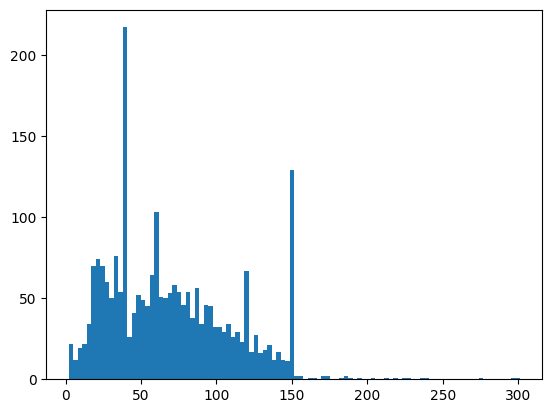

In [15]:
# create histogram of frame count
plt.hist(df_overview['Frame Count'], bins=100)

print("Frame Count Stats:")
print(df_overview['Frame Count'].describe())

frame_value_counts = df_overview['Frame Count'].value_counts()
print("\nhow often do we have <10 frames?")
print(frame_value_counts[frame_value_counts.index < 10])

In [16]:
df_overview['Frame Count'].describe()

count    2322.000000
mean       70.042636
std        42.074516
min         2.000000
25%        38.000000
50%        62.000000
75%        97.000000
max       301.000000
Name: Frame Count, dtype: float64

In [9]:
df_overview

,PatID,Acquisition Date,Accession Number,Protocol Name_Acquisition Number,SOP Instance UID,Birth Year,Age,Sex,Manufacturer,Manufacturer's Model Name,Device Serial Number,Image/ Video Identifier,Comments about the Image/ Video,Is_Video,Frame Count
0,1000159621,2014-07-01,3269432939558174,Oesoph._1,1.2.276.0.76.3.1.56.5.6.1.31078117531770503303...,1945,68,M,Siemens,AXIOM-Artis,57031,1000159621_1,NaN,True,78
1,1000159621,2014-07-01,3269432939558174,Oesoph._2,1.2.276.0.76.3.1.56.5.6.1.32279215018154090168...,1945,68,M,Siemens,AXIOM-Artis,57031,1000159621_2,NaN,True,94
2,1005454012,2011-02-08,2366879155568522,Oesoph._1,1.2.276.0.76.3.1.56.5.6.1.97540909922323301728...,1951,59,M,Siemens,AXIOM-Artis,57031,1005454012_1,NaN,True,91
3,1005454012,2011-02-08,2366879155568522,Oesoph._2,1.2.276.0.76.3.1.56.5.6.1.26312558241286149973...,1951,59,M,Siemens,AXIOM-Artis,57031,1005454012_2,NaN,True,58
4,1005454012,2011-02-08,2366879155568522,Oesoph._4,1.2.276.0.76.3.1.56.5.6.1.16702611579908065606...,1951,59,M,Siemens,AXIOM-Artis,57031,1005454012_3,NaN,True,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3012,9908293473,2012-01-31,2541171521740432,Oesoph._5,1.2.276.0.76.3.1.56.5.6.1.12554096475031024446...,1958,54,F,Siemens,AXIOM-Artis,57031,9908293473_5,NaN,True,39
3013,9926800545,2003-07-07,2968092746524453,Oesoph._1,1.2.276.0.76.3.1.56.5.6.1.17177218051888395219...,1928,75,M,Siemens,AXIOM-Artis,57031,9926800545_1,NaN,True,61
3014,9977289417,2006-07-03,1096149033623390,Oesoph._1,1.2.276.0.76.3.1.56.5.6.1.16360574606819911421...,1926,79,M,Siemens,AXIOM-Artis,57031,9977289417_1,NaN,True,151
3015,9977289417,2006-07-03,1096149033623390,Oesoph._2,1.2.276.0.76.3.1.56.5.6.1.14273614021464886234...,1926,79,M,Siemens,AXIOM-Artis,57031,9977289417_2,NaN,True,106


(array([ 18.,   0., 132.,   0.,  80.,   0.,   0., 161.,   0.,  58.,   0.,
         40.,   0.,   0.,  25.,   0.,  19.,   0.,   0.,   8.,   0.,   7.,
          0.,   3.,   0.,   0.,   2.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 1.  ,  1.42,  1.84,  2.26,  2.68,  3.1 ,  3.52,  3.94,  4.36,
         4.78,  5.2 ,  5.62,  6.04,  6.46,  6.88,  7.3 ,  7.72,  8.14,
         8.56,  8.98,  9.4 ,  9.82, 10.24, 10.66, 11.08, 11.5 , 11.92,
        12.34, 12.76, 13.18, 13.6 , 14.02, 14.44, 14.86, 15.28, 15.7 ,
        16.12, 16.54, 16.96, 17.38, 17.8 , 18.22, 18.64, 19.06, 19.48,
        19.9 , 20.32, 20.74, 21.16, 21.58, 22.  ]),
 <BarContainer object of 50 artists>)

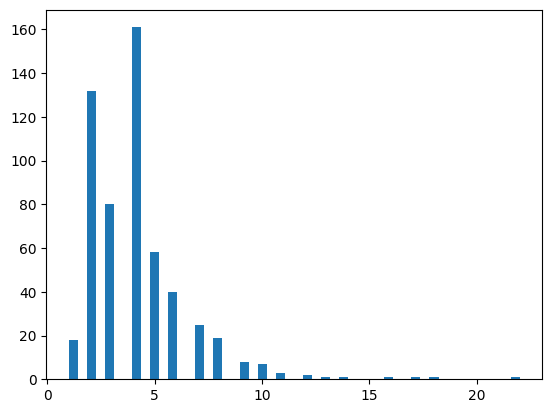

In [10]:
# how many video ids do we have per patient - group by PatID
#print(df_overview.groupby('PatID').size().sort_values(ascending=False))
# create histogram
plt.hist(df_overview.groupby('PatID').size(), bins=50)

In [11]:
df_overview.head()

,PatID,Acquisition Date,Accession Number,Protocol Name_Acquisition Number,SOP Instance UID,Birth Year,Age,Sex,Manufacturer,Manufacturer's Model Name,Device Serial Number,Image/ Video Identifier,Comments about the Image/ Video,Is_Video,Frame Count
0,1000159621,2014-07-01,3269432939558174,Oesoph._1,1.2.276.0.76.3.1.56.5.6.1.31078117531770503303...,1945,68,M,Siemens,AXIOM-Artis,57031,1000159621_1,NaN,True,78
1,1000159621,2014-07-01,3269432939558174,Oesoph._2,1.2.276.0.76.3.1.56.5.6.1.32279215018154090168...,1945,68,M,Siemens,AXIOM-Artis,57031,1000159621_2,NaN,True,94
2,1005454012,2011-02-08,2366879155568522,Oesoph._1,1.2.276.0.76.3.1.56.5.6.1.97540909922323301728...,1951,59,M,Siemens,AXIOM-Artis,57031,1005454012_1,NaN,True,91
3,1005454012,2011-02-08,2366879155568522,Oesoph._2,1.2.276.0.76.3.1.56.5.6.1.26312558241286149973...,1951,59,M,Siemens,AXIOM-Artis,57031,1005454012_2,NaN,True,58
4,1005454012,2011-02-08,2366879155568522,Oesoph._4,1.2.276.0.76.3.1.56.5.6.1.16702611579908065606...,1951,59,M,Siemens,AXIOM-Artis,57031,1005454012_3,NaN,True,19


In [12]:
# how many videos have comments
print("How many videos have No comments?")
print(df_overview['Comments about the Image/ Video'].isna().value_counts())


How many videos have No comments?
Comments about the Image/ Video
True     2253
False      69
Name: count, dtype: int64




Observations:

- some videos have 0 frames (are pngs) -> not useful -> remove

- overview png vs mp4:
    - Number of video files: 2322
    - Number of png files: 695
    - Total number of files: 3017

- orientation detection has to be used

- overview excel videos per patient inaccurate since dicom folders of some had >20 video ids -> these were single frames instead of videos -> was fixed in extracted_videos_and_images folder -> use that folder to analyse videos per patient ratio


- observation: per patient we have multiple perspectives (in seperate folders) with one video per perspective; mostly the first video (asc) has the correct perspective we need. So one could try just parsing the first folder of each patient; for better results one could also run Classification CNN on the first frame of each video to identify the correct perspective and choose the one with highest classfication score


In [13]:
# how many patients
df_overview['PatID'].nunique()

559

In [14]:
df_overview.head()

,PatID,Acquisition Date,Accession Number,Protocol Name_Acquisition Number,SOP Instance UID,Birth Year,Age,Sex,Manufacturer,Manufacturer's Model Name,Device Serial Number,Image/ Video Identifier,Comments about the Image/ Video,Is_Video,Frame Count
0,1000159621,2014-07-01,3269432939558174,Oesoph._1,1.2.276.0.76.3.1.56.5.6.1.31078117531770503303...,1945,68,M,Siemens,AXIOM-Artis,57031,1000159621_1,NaN,True,78
1,1000159621,2014-07-01,3269432939558174,Oesoph._2,1.2.276.0.76.3.1.56.5.6.1.32279215018154090168...,1945,68,M,Siemens,AXIOM-Artis,57031,1000159621_2,NaN,True,94
2,1005454012,2011-02-08,2366879155568522,Oesoph._1,1.2.276.0.76.3.1.56.5.6.1.97540909922323301728...,1951,59,M,Siemens,AXIOM-Artis,57031,1005454012_1,NaN,True,91
3,1005454012,2011-02-08,2366879155568522,Oesoph._2,1.2.276.0.76.3.1.56.5.6.1.26312558241286149973...,1951,59,M,Siemens,AXIOM-Artis,57031,1005454012_2,NaN,True,58
4,1005454012,2011-02-08,2366879155568522,Oesoph._4,1.2.276.0.76.3.1.56.5.6.1.16702611579908065606...,1951,59,M,Siemens,AXIOM-Artis,57031,1005454012_3,NaN,True,19


# Analyze data

How many patients?

In [15]:
df_overview['PatID'].nunique()

559

### Analyze Acquisition dates

Are acquisition dates consistent per patient?

In [17]:
# Group by PatID and check for consistency in Acquisition Date
inconsistent_patients_acquisition = df_overview.groupby('PatID')['Acquisition Date'].nunique()

# Filter for patients with more than one unique acquisition date
inconsistent_acquisitions_patient_ids = inconsistent_patients_acquisition[inconsistent_patients_acquisition > 1].index.tolist()

df_inconsistent_acquisition = df_overview[df_overview['PatID'].isin(inconsistent_acquisitions_patient_ids)].groupby('PatID')['Acquisition Date'].agg(['nunique', 'min', 'max'])
df_inconsistent_acquisition['Max Time Difference (days)'] = (df_inconsistent_acquisition['max'] - df_inconsistent_acquisition['min']).dt.days
df_inconsistent_acquisition#.head()

,nunique,min,max,Max Time Difference (days)
PatID,,,,
1097222869,2,2007-08-20,2008-04-14,238
1103425170,2,2008-10-11,2009-04-27,198
1119842656,2,2008-09-08,2010-04-19,588
1128249220,3,2006-11-11,2010-07-26,1353
1145365666,3,2008-06-28,2014-02-10,2053
...,...,...,...,...
7182296843,2,2006-02-18,2006-02-26,8
7360470715,2,2005-09-26,2005-12-03,68
7495261681,2,2007-05-05,2009-06-29,786


In [ ]:
#pd.set_option('display.max_rows', None)
#df_inconsistent_acquisition

(array([26., 10.,  9.,  5.,  6.,  2.,  3.,  3.,  0.,  2.]),
 array([   8. ,  212.5,  417. ,  621.5,  826. , 1030.5, 1235. , 1439.5,
        1644. , 1848.5, 2053. ]),
 <BarContainer object of 10 artists>)

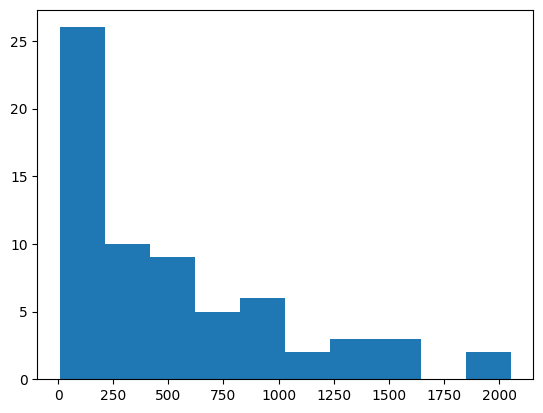

In [180]:
# plot max time difference as histogram
plt.hist(df_inconsistent_acquisition['Max Time Difference (days)'], bins=10)

<Axes: xlabel='Acquisition Date'>

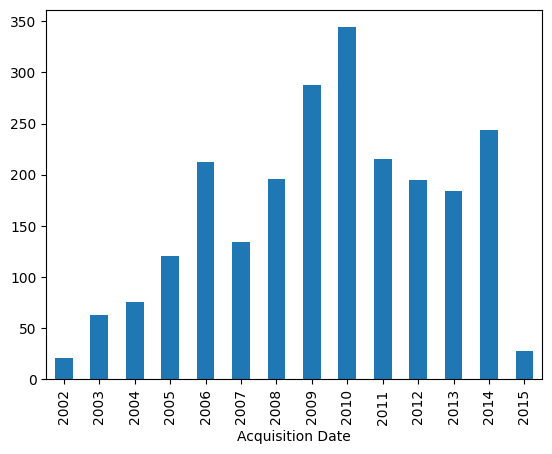

In [182]:
# plot distribution of acquisition dates per year
df_overview['Acquisition Date'].dt.year.value_counts().sort_index().plot(kind='bar')

### Patient Information

gender

In [197]:
df_overview.head()
#
df_gender = df_overview[["PatID", "Sex"]].drop_duplicates()
print(df_gender["Sex"].value_counts())
print(round(df_gender["Sex"].value_counts() / len(df_gender), 2))

Sex
M    361
F    198
Name: count, dtype: int64
Sex
M    0.65
F    0.35
Name: count, dtype: float64


age

In [205]:
# for age column, remove last char from string and convert to int
df_overview["Age"] = df_overview["Age"].apply(lambda x: int(x[:-1]))

C:\Users\ly37xoco\AppData\Local\Temp\ipykernel_3924\1587751448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_overview["Age"] = df_overview["Age"].apply(lambda x: int(x[:-1]))


Age Stats:
count    2322.000000
mean       61.346684
std        12.825611
min         4.000000
25%        55.000000
50%        62.000000
75%        70.000000
max        91.000000
Name: Age, dtype: float64


(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  11.,   4.,
          0.,   4.,   8.,  25.,  13.,  22.,  14.,  32.,   0.,  39.,  29.,
         17.,  15.,  35.,  79.,  23.,  68., 118., 171., 123., 143., 157.,
        119.,  99., 151., 120., 135.,  38.,  93., 101.,  79.,  52.,  57.,
         38.,  47.,  17.,  10.,  10.,   4.]),
 array([ 4.  ,  5.74,  7.48,  9.22, 10.96, 12.7 , 14.44, 16.18, 17.92,
        19.66, 21.4 , 23.14, 24.88, 26.62, 28.36, 30.1 , 31.84, 33.58,
        35.32, 37.06, 38.8 , 40.54, 42.28, 44.02, 45.76, 47.5 , 49.24,
        50.98, 52.72, 54.46, 56.2 , 57.94, 59.68, 61.42, 63.16, 64.9 ,
        66.64, 68.38, 70.12, 71.86, 73.6 , 75.34, 77.08, 78.82, 80.56,
        82.3 , 84.04, 85.78, 87.52, 89.26, 91.  ]),
 <BarContainer object of 50 artists>)

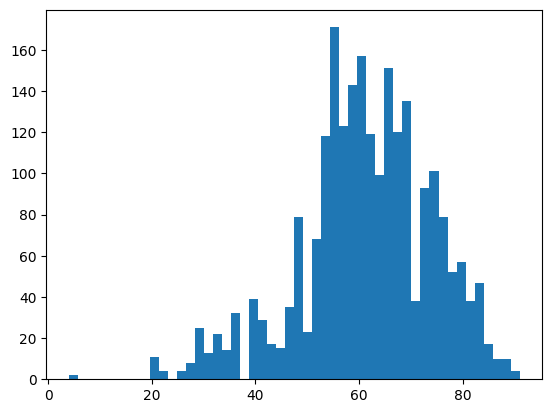

In [211]:
# plot distribution of age
print("Age Stats:")
print(df_overview["Age"].describe())
plt.hist(df_overview["Age"], bins=50)

In [212]:
df_overview.head()

,PatID,Acquisition Date,Accession Number,Protocol Name_Acquisition Number,SOP Instance UID,Birth Year,Age,Sex,Manufacturer,Manufacturer's Model Name,Device Serial Number,Image/ Video Identifier,Comments about the Image/ Video,Is_Video,Frame Count
0,1000159621,2014-07-01,3269432939558174,Oesoph._1,1.2.276.0.76.3.1.56.5.6.1.31078117531770503303...,1945,68,M,Siemens,AXIOM-Artis,57031,1000159621_1,NaN,True,78
1,1000159621,2014-07-01,3269432939558174,Oesoph._2,1.2.276.0.76.3.1.56.5.6.1.32279215018154090168...,1945,68,M,Siemens,AXIOM-Artis,57031,1000159621_2,NaN,True,94
2,1005454012,2011-02-08,2366879155568522,Oesoph._1,1.2.276.0.76.3.1.56.5.6.1.97540909922323301728...,1951,59,M,Siemens,AXIOM-Artis,57031,1005454012_1,NaN,True,91
3,1005454012,2011-02-08,2366879155568522,Oesoph._2,1.2.276.0.76.3.1.56.5.6.1.26312558241286149973...,1951,59,M,Siemens,AXIOM-Artis,57031,1005454012_2,NaN,True,58
4,1005454012,2011-02-08,2366879155568522,Oesoph._4,1.2.276.0.76.3.1.56.5.6.1.16702611579908065606...,1951,59,M,Siemens,AXIOM-Artis,57031,1005454012_3,NaN,True,19


age distribution per gender

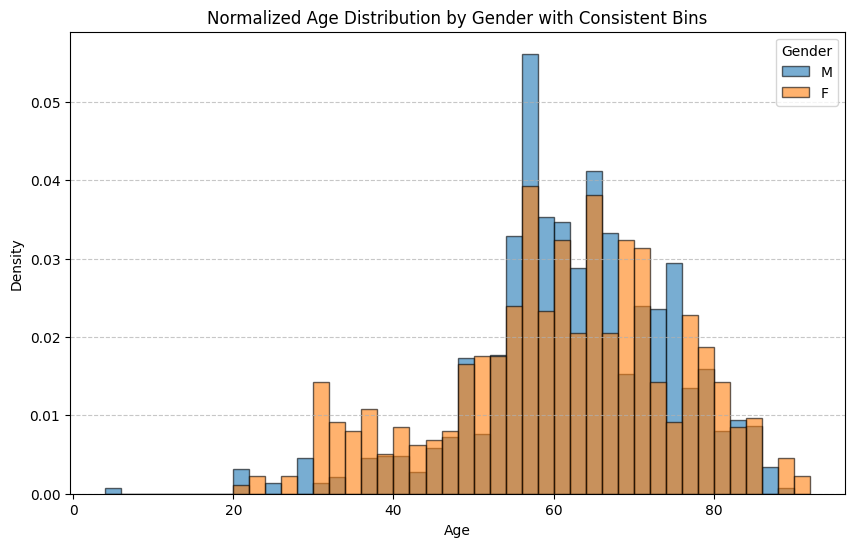

In [220]:
# Adjust bins to be consistent for both genders
plt.figure(figsize=(10, 6))

# Determine a consistent bin range for both genders
min_age = df_overview["Age"].min()
max_age = df_overview["Age"].max()
bins = range(min_age, max_age + 2, 2)  # Bin width of 2 years

for gender in df_overview["Sex"].unique():
    subset = df_overview[df_overview["Sex"] == gender]
    plt.hist(subset["Age"], bins=bins, alpha=0.6, density=True, label=f"{gender}", edgecolor='black')

plt.title("Normalized Age Distribution by Gender with Consistent Bins")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend(title="Gender")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Data Observations:
- for some patients (60) we have videos with different acquisition dates
    - how to deal with this?


- gender distribution: more men
    - men: 65%
    - woman: 35%
        - 1:2 ratio

- age distribution:
    - mean: 61
    - std: 13
    - min: 4
    - median: 62
    - max: 91

- age distribution per gender:
    - overall similar
    - more younger women (<45)
    - more older men (50-78)
    - oldest people in the study are women)

### Diagnosis and Procedures

In [6]:
diagnosis_path = r"\\fauad.fau.de\shares\ANKI\Projects\Swallowing\Data\from_Kopp\Diagnosen und Prozeduren\Diagnosen_pseudonymisiert.csv"
df_diagnosis = pd.read_csv(diagnosis_path)
df_diagnosis

,PATIENT_ID,FALL_ID,ICD_CODE,DIAGNOSE_DATUM,GEWISSHEIT_ID
0,2676810494,f-dysphagie.8R7M2C,R13.0,2006-08-14,
1,1708038698,f-dysphagie.J8APDL,C10.9,2006-09-25,ZN
2,1708038698,f-dysphagie.J8APDL,J38.6,2006-09-25,
3,1708038698,f-dysphagie.J8APDL,L58.1,2006-09-25,
4,1708038698,f-dysphagie.J8APDL,R13.9,2006-09-25,
...,...,...,...,...,...
3736,2229969900,f-dysphagie.K0CZ0L,K22.2,2007-04-23,
3737,2229969900,f-dysphagie.K0CZ0L,R13.9,2007-04-23,
3738,2229969900,f-dysphagie.K0CZ0L,Z92.3,2007-04-23,
3739,2229969900,f-dysphagie.K0CZ0L,Z92.6,2007-04-23,


Why multiple rows per patient?
- because of icd code

In [11]:
df_diagnosis.groupby('PATIENT_ID').size().sort_values(ascending=False)

PATIENT_ID
1911001813    82
1145365666    39
4647431520    35
1375140102    25
2113244667    25
              ..
1164537667     1
8285209056     1
1010125904     1
9926800545     1
9977289417     1
Length: 542, dtype: int64

In [16]:
# show all other columns for group by patient id per patient
df_diagnosis[df_diagnosis["PATIENT_ID"] == 1911001813]#.groupby('PATIENT_ID')

,PATIENT_ID,FALL_ID,ICD_CODE,DIAGNOSE_DATUM,GEWISSHEIT_ID
3481,1911001813,f-dysphagie.KL2DQN,A40.2,2013-04-17,
3482,1911001813,f-dysphagie.KL2DQN,A41.9,2013-05-06,
3483,1911001813,f-dysphagie.KL2DQN,B37.0,2013-04-17,
3484,1911001813,f-dysphagie.KL2DQN,B95.2,2013-04-17,
3485,1911001813,f-dysphagie.KL2DQN,B96.2,2013-04-17,
...,...,...,...,...,...
3558,1911001813,f-dysphagie.KL2DQN,Z48.0,2013-04-17,
3559,1911001813,f-dysphagie.KL2DQN,Z74.0,2013-05-12,
3560,1911001813,f-dysphagie.KL2DQN,Z74.1,2013-04-17,
3561,1911001813,f-dysphagie.KL2DQN,Z74.1,2013-05-12,


type of diagnosis

In [7]:
df_diagnosis["FALL_ID"].value_counts()

FALL_ID
f-dysphagie.KL2DQN    82
f-dysphagie.R1MDJ5    35
f-dysphagie.ZX28EK    25
f-dysphagie.THE8AR    24
f-dysphagie.8U9EZN    22
                      ..
f-dysphagie.WPFJK3     1
f-dysphagie.H8LA1N     1
f-dysphagie.TMAMJ4     1
f-dysphagie.P2937C     1
f-dysphagie.8R7M2C     1
Name: count, Length: 624, dtype: int64

diagnosis confidence
info:
- ZN    Zustand nach
- VA    Verdachtsdiagnose
- GE    gesicherte Diagnose
- AU    ausgeschlossene Diagnose
- „ein Leerzeichen“
    - -> bei ambulanten Fällen: Annahme gesicherte Diagnose
    - -> bei stationären Fällen: GEWISSHEIT_ID ist immer leer

In [8]:
df_diagnosis["GEWISSHEIT_ID"].value_counts()

GEWISSHEIT_ID
      3019
GE     368
ZN     243
AU      84
VA      27
Name: count, dtype: int64

Diagnosis Procedures Observations
- What is ICD Code?
- OPS Code?
- Any meaning/importance?

### look at videos

\\fauad.fau.de\shares\ANKI\Projects\Swallowing\Data\from_Kopp\extracted_videos_and_images\1000159621_1.mp4


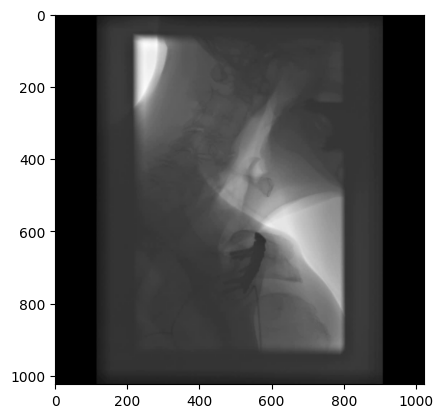

In [9]:
df_video_files.head()
# get first video and load in cv
video_path = os.path.join(videos_path, df_video_files.iloc[0, 0] + '.mp4')
print(video_path)
cap = cv2.VideoCapture(video_path)
# show first frame
ret, frame = cap.read()
plt.imshow(frame)


In [10]:
pip install numpy scipy

  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/aa/7d/43ab67228ef98c6b5dd42ab386eae2d7877036970a0d7e3dd3eb47a0d530/scipy-1.14.1-cp312-cp312-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     -------------------------------- ----- 51.2/60.8 kB 871.5 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 815.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   ---------------------------------------- 0.4/44.5 MB 11.2 MB/s eta 0:00:04
    --------------------------------------- 1.0/44.5 MB 10.5 MB/s eta 0:00:05
   - -------------------------------------- 2.0/44.5 MB 14.3 MB/s eta 0:00:03
   --- ------------------------------------ 3.5/44.5 MB 20.5 MB/s eta 0:00:03
   ----- ---------------------------------- 5.8/44.5 MB 24.8 MB/s eta 0:00:02
   -------- ------------------------------- 9.4/44.5 MB 33.5 MB/s eta 0:00:02
   ------------- --------


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import numpy as np
import cv2
from scipy.stats import entropy

In [12]:
gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
_bins = 128

hist, _ = np.histogram(gray_image.ravel(), bins=_bins, range=(0, _bins))

prob_dist = hist / hist.sum()
image_entropy = entropy(prob_dist, base=2)
print(f"Image Entropy {image_entropy}")

Image Entropy 5.120554855875849


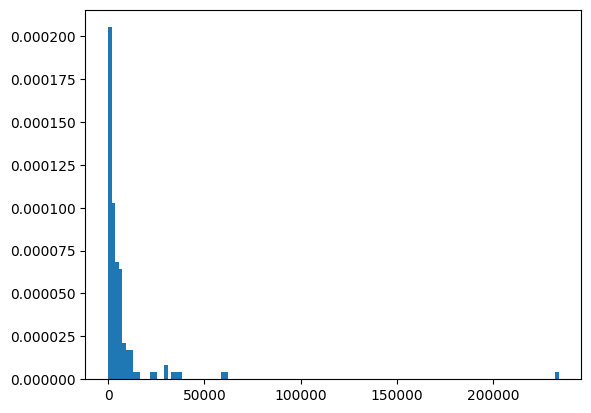

In [13]:
plt.hist(hist, density=1, bins=_bins)

plt.show()

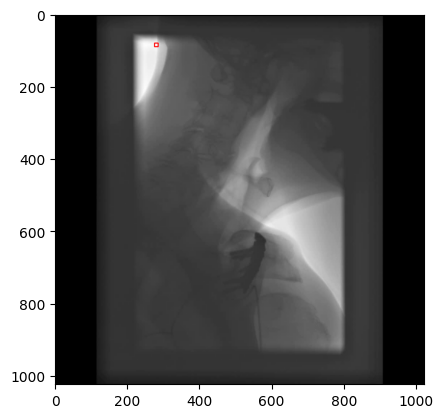

In [17]:
# can you mark the highest intensity pixel in the image with red square

# get max intensity pixel
max_intensity = np.argmax(gray_image)
max_intensity_x = max_intensity % gray_image.shape[1]
max_intensity_y = max_intensity // gray_image.shape[1]

# draw rectangle
cv2.rectangle(frame, (max_intensity_x - 5, max_intensity_y - 5), (max_intensity_x + 5, max_intensity_y + 5), (255, 0, 0), 2)
plt.imshow(frame)


In [6]:
videos_path = '\\\\fauad.fau.de\\shares\\ANKI\\Projects\\Swallowing\\Data\\from_Kopp\\extracted_videos_and_images'

video_path = '\\\\fauad.fau.de\\shares\\ANKI\\Projects\\Swallowing\\Data\\from_Kopp\\extracted_videos_and_images\\1000159621_1.mp4'

NIQE Scores

In [7]:
#get full first video in scikit-video
import skvideo # note: skvideo is pain to work with -> i use custom version: pip install -e .
import skvideo.measure
from skvideo.io import vread
import numpy as np
np.float = np.float64
np.int = np.int_
import skvideo.measure
from skvideo.io import vread
import numpy as np
from PIL import Image

# Ensure compatibility with current NumPy (optional warning fixes)
np.float = np.float64
np.int = np.int_

# Load the video
video = vread(video_path)

print(f"Original video shape: {video.shape}")

# Convert to grayscale if not already (use only the first channel)
if len(video.shape) == 4:  # If the video has channels
    video = video[:, :, :, 0]  # Extract the luminance channel (grayscale)

print(f"Grayscale video shape: {video.shape}")

# Compute the NIQE score
niqe = skvideo.measure.niqe(video)
print(f"NIQE Score: {niqe}")




Original video shape: (78, 1024, 1024, 3)
Grayscale video shape: (78, 1024, 1024)
NIQE Score: [12.977497  13.405649  13.4932    13.309358  13.472361  13.442612
 13.507538  13.058477  13.2384405 13.174794  13.057088  13.095719
 13.577167  13.986195  14.03071   13.761334  13.554802  13.215727
 13.271369  12.843791  12.710511  12.646645  13.098     12.903185
 12.969898  13.08828   13.669262  13.412067  13.106654  12.9810295
 13.821232  13.189016  12.894351  12.946666  12.899243  13.307421
 13.428421  13.922752  13.467319  12.961898  13.553516  13.419658
 13.254511  13.376183  13.972226  13.263348  13.043473  13.408605
 13.517537  13.705901  13.564634  13.12508   12.953926  12.949229
 13.16348   12.845766  13.20969   12.963207  12.765184  13.266881
 13.7836075 13.7052355 13.6956215 13.355374  13.08418   12.541992
 12.505249  13.22936   13.128313  12.583108  12.357601  12.780963
 13.455724  13.418951  13.188666  13.059537  12.683445  12.619359 ]


In [10]:
from pathlib import Path

def compute_video_niqe(video_path, first_frame_only=False):
    """
    Compute the NIQE score for a video, either across all frames or just the first frame.

    Parameters:
    - video_path (str): Path to the video file.
    - first_frame_only (bool): If True, compute NIQE for only the first frame.

    Returns:
    - float: Median NIQE score (or NIQE score for the first frame if `first_frame_only` is True).
    """
    # Load the video
    video = vread(video_path)
    print(f"Processing video: {video_path}")
    #print(f"Original video shape: {video.shape}")

    # Convert to grayscale if not already (use only the first channel)
    if len(video.shape) == 4:  # If the video has channels
        video = video[:, :, :, 0]  # Extract the luminance channel (grayscale)
    #print(f"Grayscale video shape: {video.shape}")

    # Select frames
    if first_frame_only:
        video = video[:1]  # Keep only the first frame
        #print("Computing NIQE for the first frame only.")

    # Compute NIQE scores
    niqe_scores = skvideo.measure.niqe(video)
    #print(f"NIQE Scores: {niqe_scores}")

    # Compute the median score (or single score if first frame only)
    median_score = np.median(niqe_scores)
    #print(f"Median NIQE Score: {median_score}")
    return median_score

def compute_niqe_for_videos_in_path(videos_path, first_frame_only=False):
    """
    Compute NIQE scores for all videos in a directory.

    Parameters:
    - videos_path (str): Path to the directory containing video files.
    - first_frame_only (bool): If True, compute NIQE only for the first frame of each video.

    Returns:
    - dict: A dictionary with video file paths as keys and median NIQE scores as values.
    """
    # Get all video files in the directory
    video_files = [str(f) for f in Path(videos_path).rglob("*") if f.suffix in ['.mp4', '.avi', '.mkv', '.mov']]

    if not video_files:
        print(f"No video files found in {videos_path}.")
        return {}

    # Dictionary to store results
    results = {}

    # Compute NIQE for each video
    for video_path in video_files:
        try:
            median_score = compute_video_niqe(video_path, first_frame_only=first_frame_only)
            results[video_path] = median_score
        except Exception as e:
            print(f"Error processing {video_path}: {e}")
            results[video_path] = None

    return results

compute_first_frame_only = True  # Set to True to compute NIQE only for the first frame
# Compute NIQE scores for all videos in the directory
results = compute_niqe_for_videos_in_path(videos_path, first_frame_only=compute_first_frame_only)

# Display results
print("\nMedian NIQE Scores for Videos:")
for video, score in results.items():
    print(f"{video}: {score}")

# Save results to a file (optional)
with open("median_niqe_scores.txt", "w") as f:
    for video, score in results.items():
        if score is not None:
            f.write(f"{video}: {score}\n")
        else:
            f.write(f"{video}: Error\n")


Processing video: \\fauad.fau.de\shares\ANKI\Projects\Swallowing\Data\from_Kopp\extracted_videos_and_images\1000159621_1.mp4
Processing video: \\fauad.fau.de\shares\ANKI\Projects\Swallowing\Data\from_Kopp\extracted_videos_and_images\1000159621_2.mp4
Processing video: \\fauad.fau.de\shares\ANKI\Projects\Swallowing\Data\from_Kopp\extracted_videos_and_images\1005454012_1.mp4
Processing video: \\fauad.fau.de\shares\ANKI\Projects\Swallowing\Data\from_Kopp\extracted_videos_and_images\1005454012_2.mp4
Processing video: \\fauad.fau.de\shares\ANKI\Projects\Swallowing\Data\from_Kopp\extracted_videos_and_images\1005454012_3.mp4
Processing video: \\fauad.fau.de\shares\ANKI\Projects\Swallowing\Data\from_Kopp\extracted_videos_and_images\1005454012_4.mp4
Processing video: \\fauad.fau.de\shares\ANKI\Projects\Swallowing\Data\from_Kopp\extracted_videos_and_images\1008442025_1.mp4
Processing video: \\fauad.fau.de\shares\ANKI\Projects\Swallowing\Data\from_Kopp\extracted_videos_and_images\1008442025_2.mp4


In [ ]:
# check how many videos <15 frames and why